## Disc detection version1 - For Camosun

**This code use previous developments to detect, identify and organize the discs of the hanoi game and organize. "For Camosun" means that pictures samples has been taken from the 229 lab where the testing of the capstone is done**

***

The philosophy is based on a mask where each of the pixels is averaged in the Hue value. You must determine how many pixels in a certain range create a positive for disk.
After establishing a positive for disk, the position must be determined. I thought the histogram function would work but no. You have to use a "frequency" type function to determine weights and position.

*Version1: What this version does is already use the position matrix, and the key code becomes a function to make the future code more modular. The purpose of this book is to have a 3x3 matrix with the position of the disks.*

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib inline

In [2]:
#my custom modules imports
import settingsHD as glb #this import all the global variables
import hanoi_img_procHD as vidpro
import matrix_proc as mtrx


In [3]:
#basic global variables


#mask_width0 = 45  #width by pixels
mask_width0 = 50
mask_height0 = 60  #height by pixels

mask_width1 = 50  #width by pixels
#mask_height1 = 40  #height by pixels
mask_height1 = 60

#mask_width2 = 30  #width by pixels
#mask_height2 = 50  #height by pixels
mask_width2 = 50  #width by pixels
mask_height2 = 60  #height by pixels


#note: above are the custom rectangle measures, i tried to fit to a standard size for the 3 platforms. now, we call the widht and heigh a simple variable:
mask_width = 50
mask_height = 60


#x and y coordinates where the mask are set

mask_x0 = 100  # the initial point of each of the hanoi platforms
mask_y0 = 20

mask_x1 = 250  # the initial point of each of the hanoi platforms
mask_y1 = 5

mask_x2 = 470  # the initial point of each of the hanoi platforms
mask_y2 = 10



mask_x_position_dict = {'x0' : 100, 'x1': 250, 'x2' : 470}  
mask_y_position_dict = {'y0' : 20, 'y1': 5, 'y2' : 10}


sort_disc_dictionary = {'sort0' : None, 'sort1': None, 'sort2': None}



hanoi_dict = {} #dictionary used to store the images
img_quant = 21  #number of samples pictures

#the color ranges, this is setting experimentally but should be improved or looking for a theorical approach

##------ BLUE----------
L_limit_blue=np.array([98,50,50]) # setting the blue lower limit
U_limit_blue=np.array([139,255,255]) # setting the blue upper limit



##------ RED----------
L_limit_red1=np.array([0,50,50]) # setting the red part1 lower limit
U_limit_red1=np.array([10,255,255]) # setting the red part1 upper limit
L_limit_red2=np.array([160,50,50]) # setting the red part1 lower limit
U_limit_red2=np.array([179,255,255]) # setting the red part1 upper limit


##------ GREEN----------
L_limit_green=np.array([45,50,50]) # setting the green lower limit
U_limit_green=np.array([90,255,255]) # setting the green upper limit


##------ YELLOW----------
L_limit_yellow=np.array([19,100,50]) # setting the yellow lower limit
U_limit_yellow=np.array([25,255,255]) # setting the yellow upper limit






#detected position of discs matrix, for now, 2 version, using char and using integers, waiting to see which will be more useful
detected_matrix_char = np.zeros((3,3), dtype = str)
detected_matrix_num = np.zeros((3,3))



In [4]:
#function that display a unique image
def display(img, cmap='gray'):
    fig = plt.figure(figsize = (8,9))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

In [5]:

#This function is use to process the rectangle section of each stick and process looking for the colors of the disc
# Input parameter: the small rectangle that corresponds to the stick in detail. only one stick miniframe at time
# Output: the output is an array that contains the position in pixels of the disc yellow, blue and red. If the position is 0, then, no disc of this color is detected.


def detect_color(image_hsv):
   
    #local variables

    # flags that determine the detection of a disc
    b_disc_flag = False   
    r_disc_flag = False  
    g_disc_flag = False
    y_disc_flag = False

    #variables to store the total of pixels find for specific color
    b_pixels_total = 0
    b_pixels_acum =  0
    r_pixels_total = 0
    r_pixels_acum =  0
    g_pixels_total = 0
    g_pixels_acum =  0
    y_pixels_total = 0
    y_pixels_acum =  0



    #number of the row that is determined for the disc position

    b_row = 0
    r_row = 0
    g_row = 0
    y_row = 0



    #this is to find the colors in the mask, using the function inRange. To see the real color, the bitwise is used, because inRange returns only 0 and 255 to be masked
    b_mask=cv2.inRange(image_hsv,L_limit_blue,U_limit_blue)
    blue=cv2.bitwise_and(image2,image2,mask=b_mask) #this is optional, only for visualization

    r_mask1=cv2.inRange(image_hsv,L_limit_red1,U_limit_red1) #in the map, the red has 2 sections
    r_mask2=cv2.inRange(image_hsv,L_limit_red2,U_limit_red2)
    r_mask = r_mask1 + r_mask2
    red=cv2.bitwise_and(image2,image2,mask=r_mask)    #this is optional, only for visualization


    g_mask=cv2.inRange(image_hsv,L_limit_green,U_limit_green)
    #green=cv2.bitwise_and(image2,image2, mask=g_mask)  #this is optional, only for visualization

    y_mask=cv2.inRange(image_hsv,L_limit_yellow,U_limit_yellow)
    yellow=cv2.bitwise_and(image2,image2, mask=y_mask)  #this is optional, only for visualization

    #convert the mask from the 255 values to 1, i think more easy to count pixels.
    b_mask = b_mask/255
    r_mask = r_mask/255
    g_mask = g_mask/255
    y_mask = y_mask/255
    b_pixels_total = b_mask.sum()
    r_pixels_total = r_mask.sum()
    g_pixels_total = g_mask.sum()
    y_pixels_total = y_mask.sum()

    #if I have a certain threshold value of pixels, I could determine that I have a disc of that specific value.
    if b_pixels_total > 150:
        b_disc_flag = True

    if r_pixels_total > 150:
        r_disc_flag = True

    if g_pixels_total > 150:
        g_disc_flag = True    

    if y_pixels_total > 150:
        y_disc_flag = True    
        
#then, if I have a flag for a specific disc, I must search its position in the mask, from top to down.

    if b_disc_flag:

        for i in range (0, mask_height):
            b_pixels_acum += b_mask[i].sum() 
            b_row = i

            if b_pixels_acum > 175:
                b_pixels_acum = 0  #pilas que esto es lo nuevo, no se si funcione
                break

    if r_disc_flag:

        for i in range (0, mask_height):
            r_pixels_acum += r_mask[i].sum() 
            r_row = i

            if r_pixels_acum > 175:
                r_pixels_acum = 0 #pilas que esto es lo nuevo
                break    

    if g_disc_flag:

        for i in range (0, mask_height):
            g_pixels_acum += g_mask[i].sum() 
            g_row = i

            if g_pixels_acum > 175:
                g_pixels_acum = 0 #pilas que esto es lo nuevo
                break  

    if y_disc_flag:

        for i in range (0, mask_height):
            y_pixels_acum += y_mask[i].sum() 
            y_row = i

            if y_pixels_acum > 175:
                y_pixels_acum = 0 #pilas que esto es lo nuevo
                break  

    sort = [['Y', y_row],['B', b_row],['R', r_row]] 
    sort = sorted(sort, key=lambda x: x[1])
    return sort, blue, yellow, red
        

In [6]:
def get_detected_matrix_char(sort_dict):
    #local variables
    detection_matrix = np.zeros((3,3), dtype = str)
    
    for n in range (0,3):
        sort = sort_dict['sort' + str(n)]
        for j in range (0,3):
            if sort[j][1] == 0:
                detection_matrix[j][n] = 0
            else:
                detection_matrix[j][n] = sort[j][0] 
    return detection_matrix        

In [7]:
def get_detected_matrix_num(sort_dict):
    #local variables
    detection_matrix = np.zeros((3,3))
    
    for n in range (0,3):
        sort = sort_dict['sort' + str(n)]
        for j in range (0,3):
            if sort[j][1] == 0:
                detection_matrix[j][n] = 0
            elif sort[j][0] == 'B':
                detection_matrix[j][n] = 1
            elif sort[j][0] == 'Y':
                detection_matrix[j][n] = 2
            elif sort[j][0] == 'R':
                detection_matrix[j][n] = 3
                    
    return detection_matrix     

In [8]:
# load the dictionary with the jpg dataset stored at DATA
for i in range (1, (img_quant+1)):

    
    #note: the files from 18 nov are the ones without the withe background
    #name_file = 'DATA/CamosunTest/hanoinov18sample (' + str(i) + ').jpg'
    name_file = 'DATA/CamosunTest/hanoinov24sample (' + str(i) + ').jpg'
    name_var = str('hanoi'+str(i))
    
    hanoi_dict[name_var] = cv2.imread(name_file)

In [9]:
#len(hanoi_dict)   #give me total elements of the dictionary

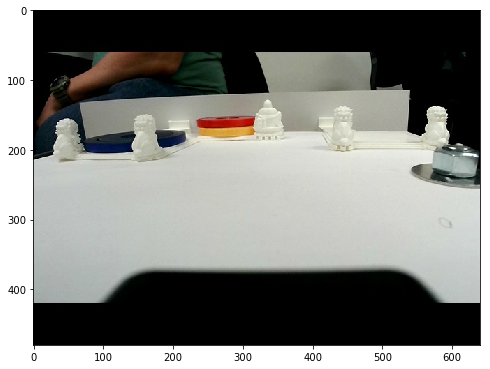

In [16]:
#load the image that I want to know the HSV value, but first look in the RGB version and also get the HSV version

img = hanoi_dict['hanoi6']
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
imagecopy = image.copy()
imagehsvcopy = imagehsv.copy()
display(image)

In [17]:
small_image = imagecopy[130:230, 0:630]
small_image_hsv = imagehsvcopy[130:230, 0:630]

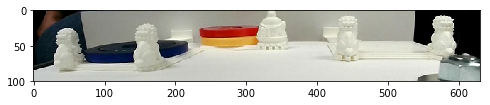

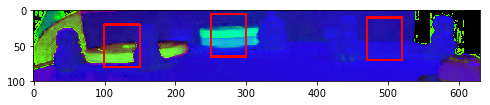

In [18]:
#this step is only to estimate where to start looking for the disc. in the final application is not necessary to draw rectangles

#image2 = cv2.rectangle(small_image, (mask_x0, mask_y0), ((mask_x0 + mask_width0), (mask_y0+mask_height0)), (0,0,255), thickness = 2)
#image2 = cv2.rectangle(small_image, (mask_x1, mask_y1), ((mask_x1 + mask_width1), (mask_y1+mask_height1)), (0,0,255), thickness = 2)
#image2 = cv2.rectangle(small_image, (mask_x2, mask_y2), ((mask_x2 + mask_width2), (mask_y2+mask_height2)), (0,0,255), thickness = 2)

image2 = cv2.rectangle(small_image_hsv, (mask_x0, mask_y0), ((mask_x0 + mask_width0), (mask_y0+mask_height0)), (255,0,0), thickness = 2)
image2 = cv2.rectangle(small_image_hsv, (mask_x1, mask_y1), ((mask_x1 + mask_width1), (mask_y1+mask_height1)), (255,0,0), thickness = 2)
image2 = cv2.rectangle(small_image_hsv, (mask_x2, mask_y2), ((mask_x2 + mask_width2), (mask_y2+mask_height2)), (255,0,0), thickness = 2)


display(small_image)
display(small_image_hsv)
    

In [13]:
#now, show me all
"""
for i in range(1, 22):
    img = hanoi_dict['hanoi' + str(i)]
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    small_image = imagecopy[130:230, 0:630]
    image2 = cv2.rectangle(small_image, (mask_x0, mask_y0), ((mask_x0 + mask_width0), (mask_y0+mask_height0)), (0,0,255), thickness = 1)
    image2 = cv2.rectangle(small_image, (mask_x1, mask_y1), ((mask_x1 + mask_width1), (mask_y1+mask_height1)), (0,0,255), thickness = 1)
    image2 = cv2.rectangle(small_image, (mask_x2, mask_y2), ((mask_x2 + mask_width2), (mask_y2+mask_height2)), (0,0,255), thickness = 1)

    display(image2)  
"""

"\nfor i in range(1, 22):\n    img = hanoi_dict['hanoi' + str(i)]\n    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n    #imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)\n    imagecopy = image.copy()\n    small_image = imagecopy[130:230, 0:630]\n    image2 = cv2.rectangle(small_image, (mask_x0, mask_y0), ((mask_x0 + mask_width0), (mask_y0+mask_height0)), (0,0,255), thickness = 1)\n    image2 = cv2.rectangle(small_image, (mask_x1, mask_y1), ((mask_x1 + mask_width1), (mask_y1+mask_height1)), (0,0,255), thickness = 1)\n    image2 = cv2.rectangle(small_image, (mask_x2, mask_y2), ((mask_x2 + mask_width2), (mask_y2+mask_height2)), (0,0,255), thickness = 1)\n\n    display(image2)  \n"

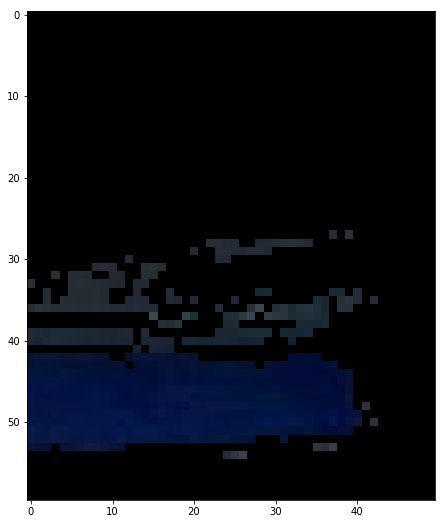

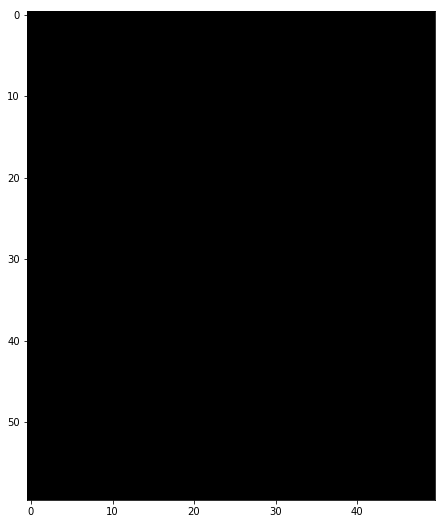

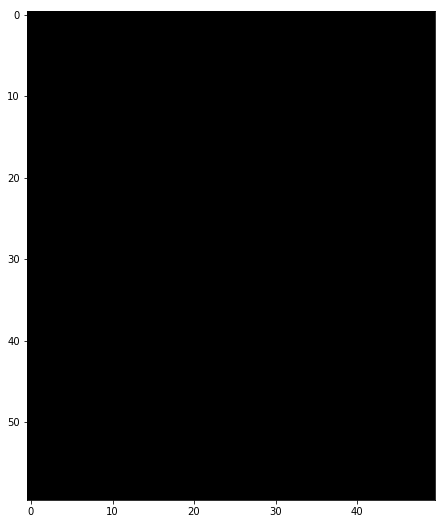

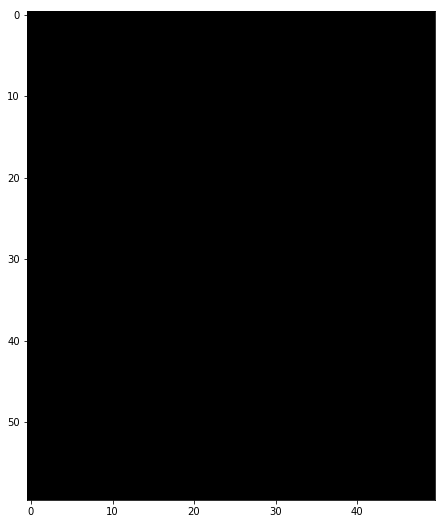

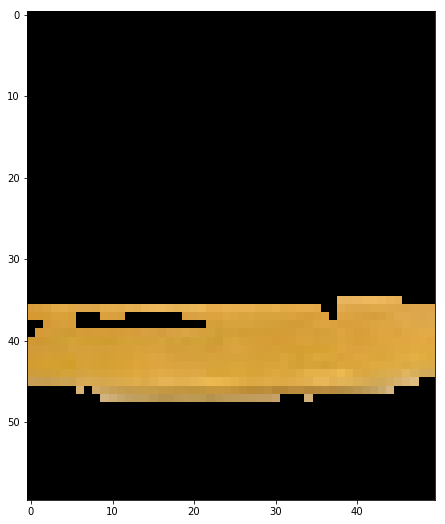

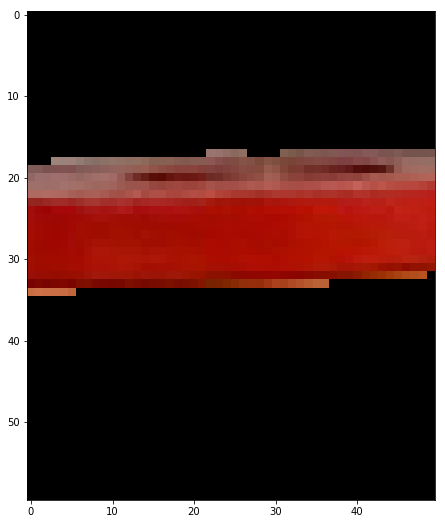

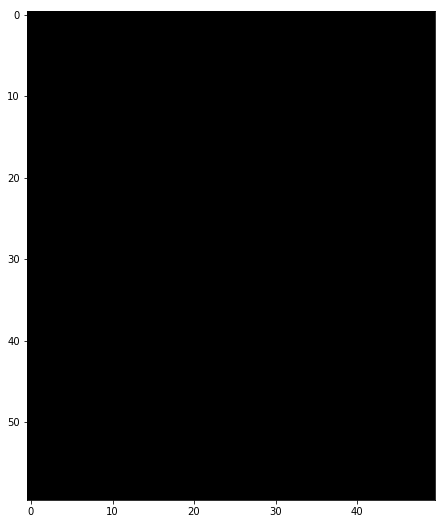

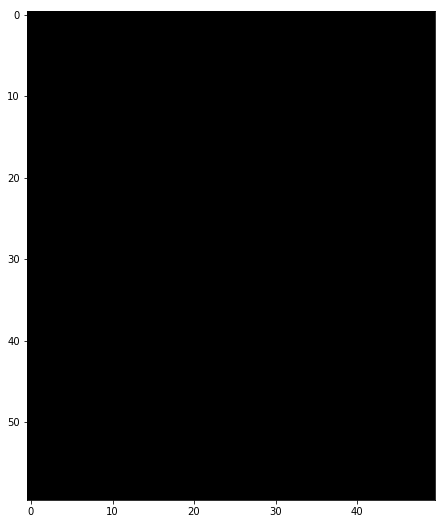

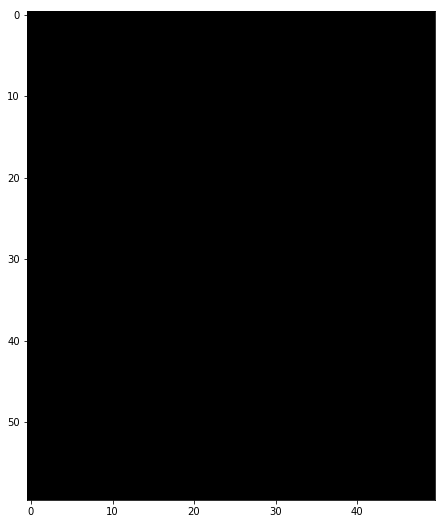

In [28]:
#after previous estimation step before, load again the image and mask the sections. there are areas sticks, then, 3 sections that positions is determined by the stick position dictionary
#image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in range(0, 3):
    image2 = small_image[mask_y_position_dict['y'+str(i)]:(mask_y_position_dict['y'+str(i)] + mask_height), int(mask_x_position_dict['x'+str(i)]):int(mask_x_position_dict['x'+str(i)]+mask_width)] #optional, only for display
    imagehsv_roi = small_image_hsv[mask_y_position_dict['y'+str(i)]:(mask_y_position_dict['y'+str(i)] + mask_height), int(mask_x_position_dict['x'+str(i)]):int(mask_x_position_dict['x'+str(i)]+mask_width)]
    #display (image2)
    sort_disc_dictionary['sort' + str(i)], blue, yellow, red = detect_color(imagehsv_roi)   #this is the custom function
    
   
    display(blue)
    display(yellow)
    display(red)

In [29]:
#only for debugging 
for i in range (0 , 3):
    print(sort_disc_dictionary['sort' + str(i)])   
    

[['Y', 0], ['R', 0], ['B', 40]]
[['B', 0], ['R', 21], ['Y', 39]]
[['Y', 0], ['B', 0], ['R', 0]]


In [30]:
#custom function to get the matrix that is already set in the hanoi game
detected_matrix_char = get_detected_matrix_char(sort_disc_dictionary)
detected_matrix_num = get_detected_matrix_num(sort_disc_dictionary)

In [31]:
detected_matrix_char

array([['0', '0', '0'],
       ['0', 'R', '0'],
       ['B', 'Y', '0']], dtype='<U1')

In [40]:
detected_matrix_num

array([[0., 0., 3.],
       [0., 0., 2.],
       [0., 0., 1.]])

In [58]:
state =  2

In [54]:
hanoi_mat= glb.hanoi_matrix_num[(3*state):(3*(state+1)), :]

In [59]:
hanoi_mat= glb.hanoi_matrix_char[(3*state):(3*(state+1)), :]

In [60]:

hanoi_mat

array([['0', '0', '0'],
       ['0', '0', '0'],
       ['R', 'Y', 'B']], dtype='<U1')

In [31]:
(detected_matrix_char == hanoi_mat).all()

False

In [58]:
blue_unique = np.append(blue_unique[0], blue_unique[1])
blue_unique

array([0., 1.])

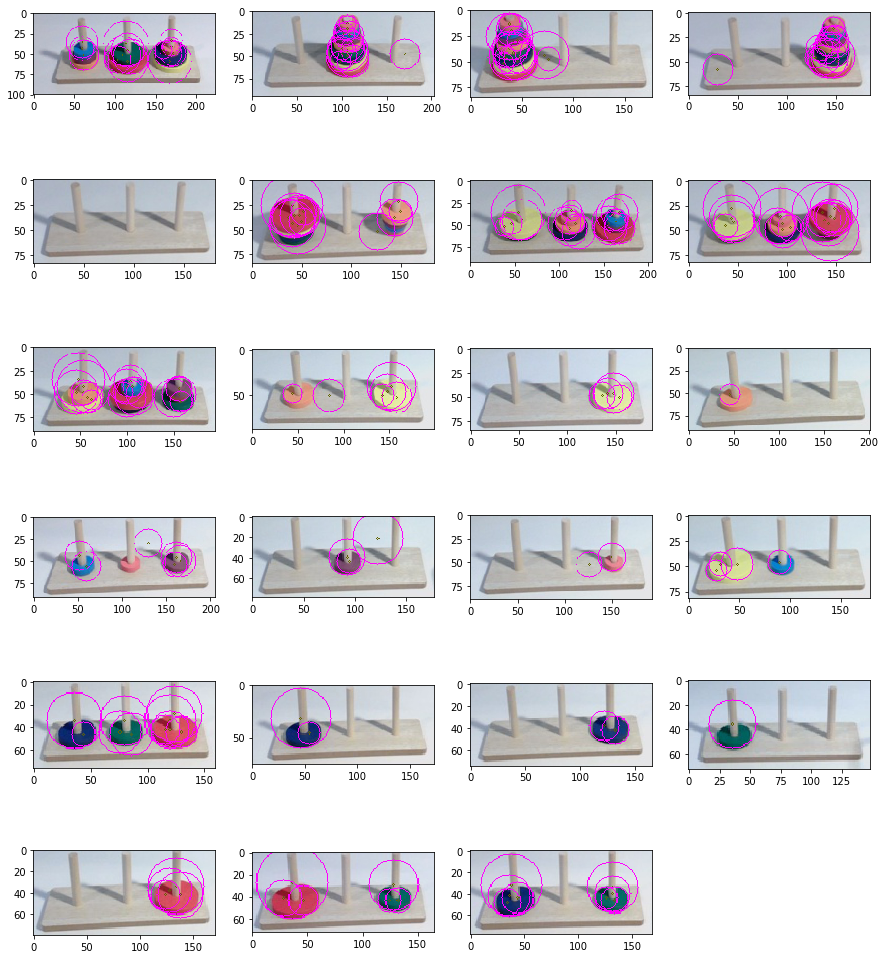

In [43]:
display_allcolor(hanoi_hough_dict)

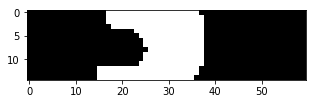

In [39]:
blue_trans =  np.transpose(b_mask)
display(blue_trans)
blue_trans = blue_trans.flatten()

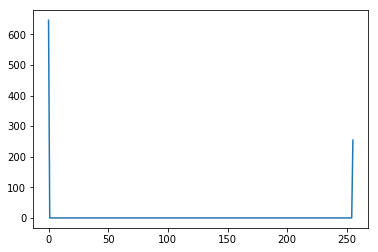

In [46]:
hist_full = cv2.calcHist([blue_trans],[0],None,[256],[0,256])
plt.plot(hist_full)

(array([8., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

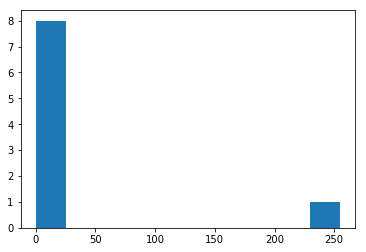

In [36]:
counts, bins = np.histogram(blue_trans)
plt.hist(counts, bins)


In [23]:
b_mask.shape
blue_trans.shape

(15, 60)

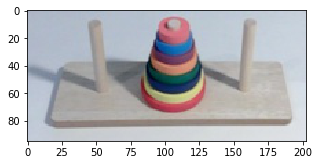

In [28]:
blue_trans


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0

In [11]:
b_mask



array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       

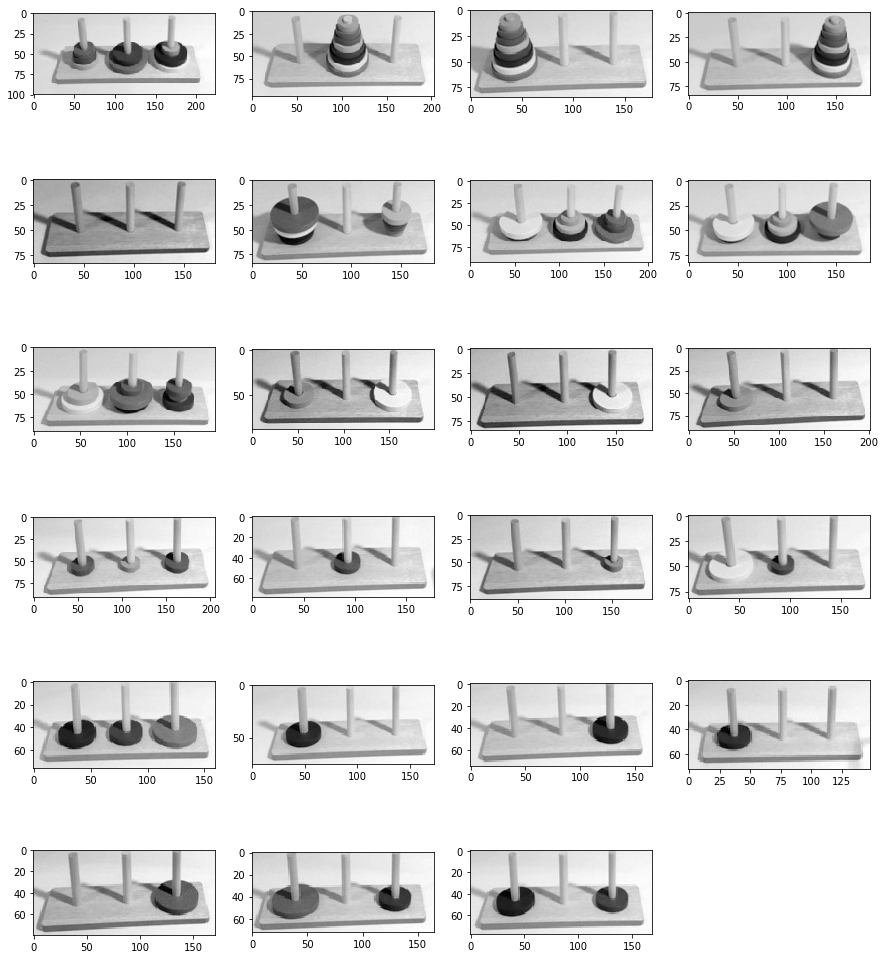

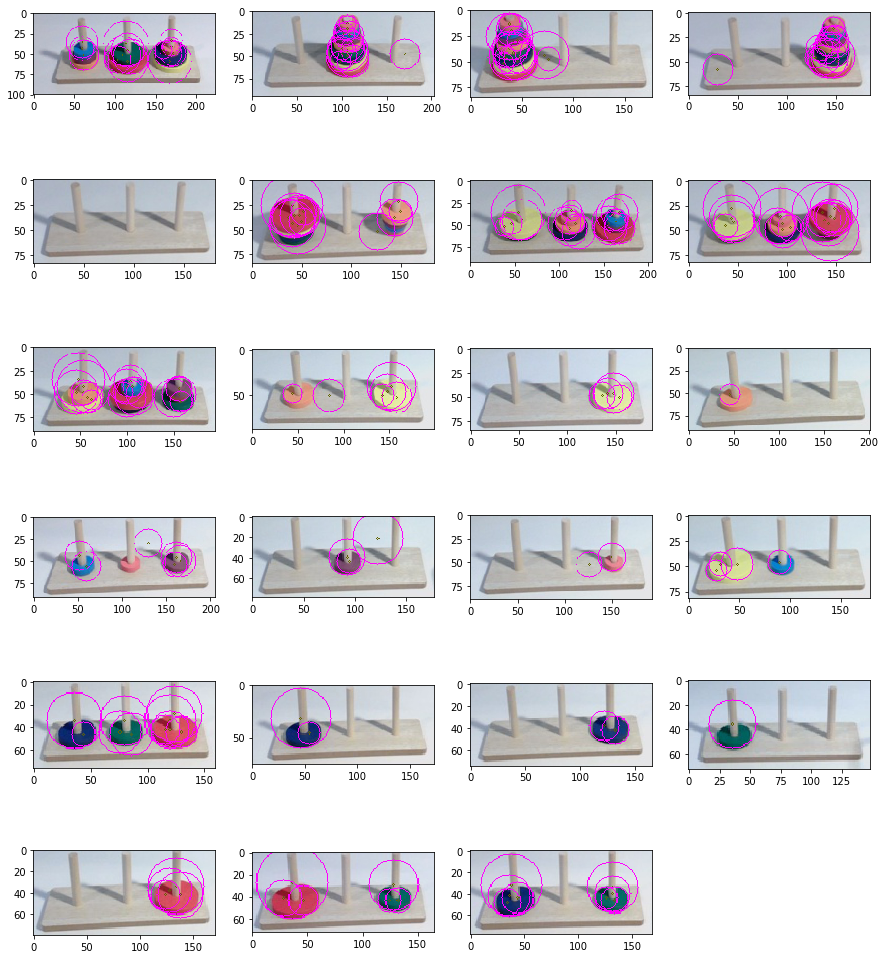

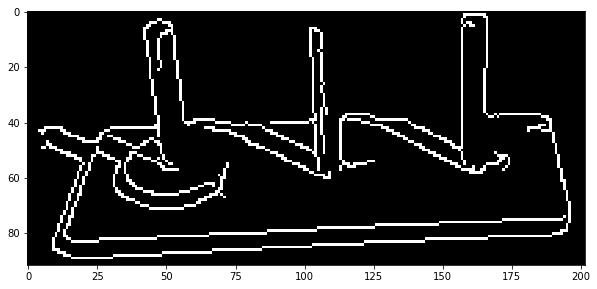

In [18]:
example

NameError: name 'example' is not defined

In [22]:
example = np.array([[0, 0, 0 ], [0, 0, 0 ], [0, 0, 1]])

In [23]:
example


array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 1]])

32

array([[[114,  44,  32],
        [172,  50,  17],
        [120,  54,  22],
        [112,  50,  21],
        [ 60,  46,  24],
        [ 64,  52,  17],
        [172,  58,  17],
        [162,  50,  14],
        [170,  40,  14]]], dtype=uint16)

(1, 9, 3)